# **Data Preparation**

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import os
import pathlib
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
import pandas as pd
import numpy as np
import cv2
import skimage
from skimage.util import random_noise
import tensorflow as tf

from tqdm.notebook import tqdm
import random

In [2]:
import sys

from sklearn.model_selection import train_test_split
from data_importer import load_training_images

noisy_array, gt_array = load_training_images('../../../../../Dataset/LowDoseCTGrandChallenge/Training_Image_Data/', load_limited_images=True, num_images_to_load=10)

_n, _g = load_training_images('../../../../../Dataset/LowDoseCTGrandChallenge/Selected_Image_Pairs/', load_limited_images=False)

noisy_array = np.concatenate((noisy_array, _n), axis=0)
gt_array = np.concatenate((gt_array, _g), axis=0)

noisy_train, noisy_test, gt_train, gt_test = train_test_split(noisy_array, gt_array, test_size=0.20, random_state=42)


loaded training images x and y of len :  10 10  respectively
type of train images x :  float64
range of values in train images :  0.00024292900950869962 0.5327063878979414
type of train images y :  float64
loaded training images x and y of len :  5 5  respectively
type of train images x :  float64
range of values in train images :  0.0 0.8479930960036455
type of train images y :  float64


In [3]:
print(noisy_train.shape)
print(noisy_test.shape)
print(gt_train.shape)
print(gt_test.shape)

(12, 256, 256, 1)
(3, 256, 256, 1)
(12, 256, 256, 1)
(3, 256, 256, 1)


In [4]:
noisy_train_images = noisy_train
noisy_test_images = noisy_test

gt_train_images = gt_train
gt_test_images = gt_test

print(noisy_train_images.shape)
print(noisy_test_images.shape)

print(gt_train_images.shape)
print(gt_test_images.shape)

(12, 256, 256, 1)
(3, 256, 256, 1)
(12, 256, 256, 1)
(3, 256, 256, 1)


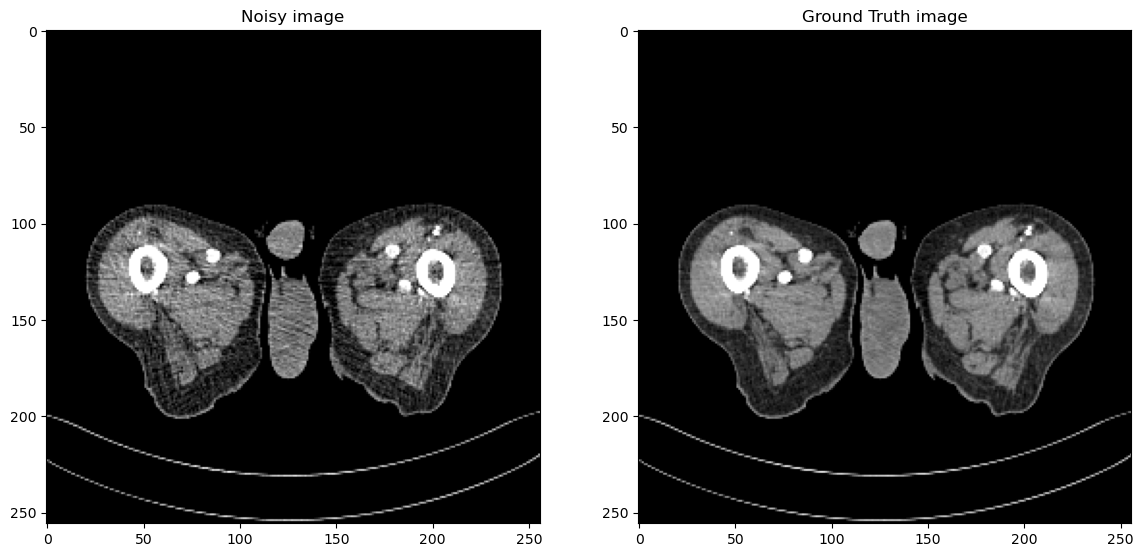

In [5]:
from data_importer import denormalize, trunc

f, axarr = plt.subplots(1,2, figsize=(14,14))
axarr[0].imshow(trunc(denormalize(noisy_train_images[5])), vmin=-160.0, vmax=240.0, cmap='gray')
axarr[0].set_title("Noisy image")
axarr[1].imshow(trunc(denormalize(gt_train_images[5])), vmin=-160.0, vmax=240.0, cmap='gray')
axarr[1].title.set_text("Ground Truth image")

In [6]:
def _up_down_flip(image, label):
    image = tf.image.flip_up_down(image)
    label = tf.image.flip_up_down(label)
    return image, label

def _left_right_flip(image, label):
    image = tf.image.flip_left_right(image)
    label = tf.image.flip_left_right(label)
    return image, label

def _rotate(image, label):
    random_angle = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, random_angle)
    label = tf.image.rot90(label, random_angle)
    return image, label

def _hue(image, label):
    rand_value = random.uniform(-1,1)
    image = tf.image.adjust_hue(image, rand_value)
    label = tf.image.adjust_hue(label, rand_value)
    return image, label

def _brightness(image, label):
    rand_value = random.uniform(-0.08,0.25)
    image = tf.image.adjust_brightness(image, rand_value)
    label = tf.image.adjust_brightness(label, rand_value)
    return image, label

def _saturation(image, label):
    rand_value = random.uniform(1, 5)
    image = tf.image.adjust_saturation(image, rand_value)
    label = tf.image.adjust_saturation(label, rand_value)
    return image, label

def _contrast(image, label):
    rand_value = random.uniform(1, 3)
    image = tf.image.adjust_contrast(image, rand_value)
    label = tf.image.adjust_contrast(label, rand_value)
    return image, label

# What does batch, repeat, and shuffle do with TensorFlow Dataset?
# https://stackoverflow.com/q/53514495/7697658
def tf_data_generator(X, y, batch_size=32, augmentations=None):
    dataset = tf.data.Dataset.from_tensor_slices((X, y)) # This is the main step for data generation
    dataset = dataset.shuffle(1000, reshuffle_each_iteration=True)

    if augmentations:
        for f in augmentations:
            if np.random.uniform(0,1)<0.5:
                dataset = dataset.map(f, num_parallel_calls=2)

    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size=batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

BATCH_SIZE=4
augmentation_lst = [_up_down_flip, _left_right_flip, _rotate]
image_generator_train = tf_data_generator(X=noisy_train_images, y=gt_train_images, batch_size=BATCH_SIZE, augmentations=augmentation_lst)
image_generator_test = tf_data_generator(X=noisy_test_images, y=gt_test_images, batch_size=BATCH_SIZE)

In [7]:
image_generator_train

<PrefetchDataset element_spec=(TensorSpec(shape=(4, 256, 256, 1), dtype=tf.float64, name=None), TensorSpec(shape=(4, 256, 256, 1), dtype=tf.float64, name=None))>

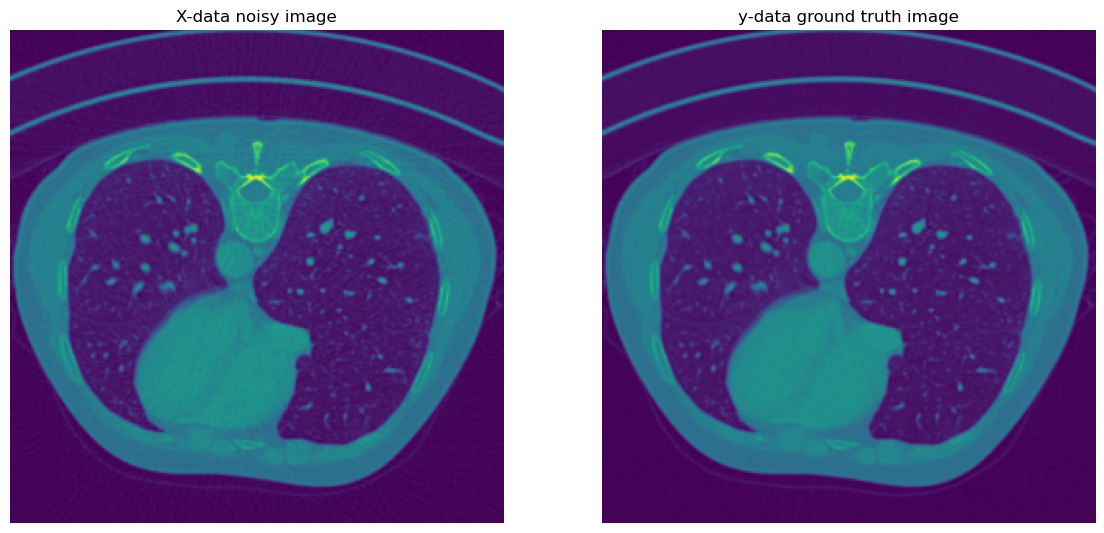

In [8]:
# SANITY CHECK of the Dataset generator
for noisy, gt in image_generator_train.take(1):  # only take first element of dataset
    numpy_images = noisy.numpy()
    numpy_labels = gt.numpy()

f, axarr = plt.subplots(1,2, figsize=(14,14))
axarr[0].imshow(numpy_images[1])
axarr[0].set_title("X-data noisy image")
axarr[0].set_axis_off()

axarr[1].imshow(numpy_labels[1])
axarr[1].set_title("y-data ground truth image")
axarr[1].set_axis_off()

# **MWCNN**

In [9]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose,\
                                    GlobalAveragePooling2D, AveragePooling2D, MaxPool2D, UpSampling2D,\
                                    BatchNormalization, Activation, ReLU, Flatten, Dense, Input,\
                                    Add, Multiply, Concatenate, Softmax
from tensorflow.keras import initializers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import softmax

tf.keras.backend.set_image_data_format('channels_last')
import keras.backend as K

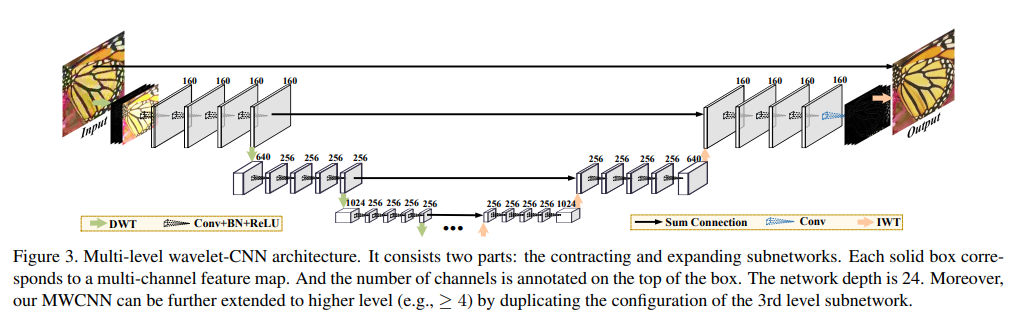

In [10]:
class Conv_block(tf.keras.layers.Layer):
    def  __init__(self, num_filters=200, kernel_size=3, **kwargs):
        super().__init__(**kwargs)
        self.num_filters=num_filters
        self.kernel_size=kernel_size
        self.conv_1 = Conv2D(filters=self.num_filters, kernel_size=self.kernel_size, padding='same')
        self.conv_2 = Conv2D(filters=self.num_filters, kernel_size=self.kernel_size, padding='same')
        self.conv_3 = Conv2D(filters=self.num_filters, kernel_size=self.kernel_size, padding='same')
        self.conv_4 = Conv2D(filters=self.num_filters, kernel_size=self.kernel_size, padding='same')

        self.bn_1 = BatchNormalization()
        self.bn_2 = BatchNormalization()
        self.bn_3 = BatchNormalization()
        self.bn_4 = BatchNormalization()
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'num_filters': self.num_filters,
            'kernel_size':self.kernel_size
        })
        return config

    def call(self, X):
        X = self.conv_1(X)
        # X = self.bn_1(X)
        X = ReLU()(X)
        X = self.conv_2(X)
        # X = self.bn_2(X)
        X = ReLU()(X)
        X = self.conv_3(X)
        # X = self.bn_3(X)
        X = ReLU()(X)
        # X = self.conv_4(X)
        # # X = self.bn_4(X)
        # X = ReLU()(X)

        return X

In [11]:
class DWT_downsampling(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def call(self, x):
        """
        The following calculations for DWT are inspired from,
        https://github.com/AureliePeng/Keras-WaveletTransform/blob/master/models/DWT.py
        """
        x1 = x[:, 0::2, 0::2, :] #x(2i−1, 2j−1)
        x2 = x[:, 1::2, 0::2, :] #x(2i, 2j-1)
        x3 = x[:, 0::2, 1::2, :] #x(2i−1, 2j)
        x4 = x[:, 1::2, 1::2, :] #x(2i, 2j)   

        x_LL = x1 + x2 + x3 + x4
        x_LH = -x1 - x3 + x2 + x4
        x_HL = -x1 + x3 - x2 + x4
        x_HH = x1 - x3 - x2 + x4

        return Concatenate(axis=-1)([x_LL, x_LH, x_HL, x_HH])

In [12]:
class IWT_upsampling(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def call(self, x):
        """
        The following calculations for IWT are inspired from,
        https://github.com/AureliePeng/Keras-WaveletTransform/blob/master/models/DWT.py
        """
        x_LL = x[:, :, :, 0:x.shape[3]//4]
        x_LH = x[:, :, :, x.shape[3]//4:x.shape[3]//4*2]
        x_HL = x[:, :, :, x.shape[3]//4*2:x.shape[3]//4*3]
        x_HH = x[:, :, :, x.shape[3]//4*3:]

        x1 = (x_LL - x_LH - x_HL + x_HH)/4
        x2 = (x_LL - x_LH + x_HL - x_HH)/4
        x3 = (x_LL + x_LH - x_HL - x_HH)/4
        x4 = (x_LL + x_LH + x_HL + x_HH)/4 

        y1 = K.stack([x1,x3], axis=2)
        y2 = K.stack([x2,x4], axis=2)
        shape = K.shape(x)
        return K.reshape(K.concatenate([y1,y2], axis=-1), K.stack([shape[0], shape[1]*2, shape[2]*2, shape[3]//4]))

In [13]:
def create_model():
    tf.keras.backend.clear_session()

    input = Input(shape=(256,256,1))

    cb_1 = Conv_block(num_filters=64)(input)
    dwt_1 = DWT_downsampling()(cb_1)

    cb_2 = Conv_block(num_filters=128)(dwt_1)
    dwt_2 = DWT_downsampling()(cb_2)

    cb_3 = Conv_block(num_filters=256)(dwt_2)
    dwt_3 = DWT_downsampling()(cb_3)

    cb_4 = Conv_block(num_filters=512)(dwt_3)
    dwt_4 = DWT_downsampling()(cb_4)

    cb_5 = Conv_block(num_filters=512)(dwt_4)
    cb_5 = BatchNormalization()(cb_5)
    cb_5 = Conv_block(num_filters=512)(cb_5)
    cb_5 = Conv2D(filters=2048, kernel_size=3, strides=1, padding='same')(cb_5)

    up = IWT_upsampling()(cb_5)
    up = Conv_block(num_filters=512)(Add()([up, cb_4]))
    up = Conv2D(filters=1024, kernel_size=3, strides=1, padding='same')(up)

    up = IWT_upsampling()(up)
    up = Conv_block(num_filters=256)(Add()([up, cb_3]))
    up = Conv2D(filters=512, kernel_size=3, strides=1, padding='same')(up)
    
    up = IWT_upsampling()(up)
    up = Conv_block(num_filters=128)(Add()([up, cb_2]))
    up = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(up)
    
    up = IWT_upsampling()(up)
    up = Conv_block(num_filters=64)(Add()([up, cb_1]))
    up = Conv2D(filters=128, kernel_size=3, strides=1, padding='same')(up)

    out = Conv2D(filters=1, kernel_size=(1, 1), padding="same")(up)

    return Model(inputs=[input], outputs=[out])

model = create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv_block (Conv_block)        (None, 256, 256, 64  74496       ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dwt_downsampling (DWT_downsamp  (None, 128, 128, 25  0          ['conv_block[0][0]']             
 ling)                          6)                                                            

# **Training**

In [14]:
steps_per_epoch_train = len(noisy_train_images)
steps_per_epoch_validation = len(noisy_test_images)

In [15]:
check_point_filepath="saved_weights/mwcnn_epochs_{epoch:02d}.h5"

callbacks_lst = [
                     tf.keras.callbacks.ModelCheckpoint(filepath=check_point_filepath, monitor='val_accuracy', verbose=1, save_best_only=False, save_weights_only=True),

    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_lr=0.0000009, min_delta=0.0001, factor=0.70, patience=3, verbose=1, mode='min'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, min_delta=0.0001, patience=10)
]

In [20]:
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=Adam(learning_rate=0.0009))
model.fit(image_generator_train, 
          validation_data=image_generator_test,
                        steps_per_epoch=steps_per_epoch_train,
                        validation_steps=steps_per_epoch_validation,
                        epochs=1,
                        verbose=1,
                        callbacks=callbacks_lst)

ResourceExhaustedError: Graph execution error:

Detected at node 'model/conv2d_44/Conv2D' defined at (most recent call last):
    File "c:\Users\Tarun\miniconda3\envs\denoising-conda-env\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\Tarun\miniconda3\envs\denoising-conda-env\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\Tarun\miniconda3\envs\denoising-conda-env\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\Tarun\miniconda3\envs\denoising-conda-env\lib\site-packages\traitlets\config\application.py", line 1053, in launch_instance
      app.start()
    File "c:\Users\Tarun\miniconda3\envs\denoising-conda-env\lib\site-packages\ipykernel\kernelapp.py", line 737, in start
      self.io_loop.start()
    File "c:\Users\Tarun\miniconda3\envs\denoising-conda-env\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\Tarun\miniconda3\envs\denoising-conda-env\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\Tarun\miniconda3\envs\denoising-conda-env\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\Tarun\miniconda3\envs\denoising-conda-env\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\Tarun\miniconda3\envs\denoising-conda-env\lib\site-packages\ipykernel\kernelbase.py", line 524, in dispatch_queue
      await self.process_one()
    File "c:\Users\Tarun\miniconda3\envs\denoising-conda-env\lib\site-packages\ipykernel\kernelbase.py", line 513, in process_one
      await dispatch(*args)
    File "c:\Users\Tarun\miniconda3\envs\denoising-conda-env\lib\site-packages\ipykernel\kernelbase.py", line 418, in dispatch_shell
      await result
    File "c:\Users\Tarun\miniconda3\envs\denoising-conda-env\lib\site-packages\ipykernel\kernelbase.py", line 758, in execute_request
      reply_content = await reply_content
    File "c:\Users\Tarun\miniconda3\envs\denoising-conda-env\lib\site-packages\ipykernel\ipkernel.py", line 426, in do_execute
      res = shell.run_cell(
    File "c:\Users\Tarun\miniconda3\envs\denoising-conda-env\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\Tarun\miniconda3\envs\denoising-conda-env\lib\site-packages\IPython\core\interactiveshell.py", line 3046, in run_cell
      result = self._run_cell(
    File "c:\Users\Tarun\miniconda3\envs\denoising-conda-env\lib\site-packages\IPython\core\interactiveshell.py", line 3101, in _run_cell
      result = runner(coro)
    File "c:\Users\Tarun\miniconda3\envs\denoising-conda-env\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\Tarun\miniconda3\envs\denoising-conda-env\lib\site-packages\IPython\core\interactiveshell.py", line 3306, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\Tarun\miniconda3\envs\denoising-conda-env\lib\site-packages\IPython\core\interactiveshell.py", line 3488, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\Tarun\miniconda3\envs\denoising-conda-env\lib\site-packages\IPython\core\interactiveshell.py", line 3548, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Tarun\AppData\Local\Temp\ipykernel_14660\1375743259.py", line 2, in <module>
      model.fit(image_generator_train,
    File "c:\Users\Tarun\miniconda3\envs\denoising-conda-env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Tarun\miniconda3\envs\denoising-conda-env\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\Tarun\miniconda3\envs\denoising-conda-env\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\Tarun\miniconda3\envs\denoising-conda-env\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Tarun\miniconda3\envs\denoising-conda-env\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\Tarun\miniconda3\envs\denoising-conda-env\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\Tarun\miniconda3\envs\denoising-conda-env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Tarun\miniconda3\envs\denoising-conda-env\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\Tarun\miniconda3\envs\denoising-conda-env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Tarun\miniconda3\envs\denoising-conda-env\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Tarun\miniconda3\envs\denoising-conda-env\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Tarun\miniconda3\envs\denoising-conda-env\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\Tarun\miniconda3\envs\denoising-conda-env\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\Tarun\miniconda3\envs\denoising-conda-env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Tarun\miniconda3\envs\denoising-conda-env\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Tarun\miniconda3\envs\denoising-conda-env\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Tarun\miniconda3\envs\denoising-conda-env\lib\site-packages\keras\layers\convolutional\base_conv.py", line 283, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "c:\Users\Tarun\miniconda3\envs\denoising-conda-env\lib\site-packages\keras\layers\convolutional\base_conv.py", line 255, in convolution_op
      return tf.nn.convolution(
Node: 'model/conv2d_44/Conv2D'
OOM when allocating tensor with shape[128,64,3,3] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/conv2d_44/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_7713]

# **Inference**

In [16]:
# Inference
def inference_single_image(model, noisy_image):
    input_image = np.expand_dims(noisy_image, axis=0)
    predicted_image = model.predict(input_image)
    a = np.abs(np.min(predicted_image))
    b = np.max(predicted_image)
    
    #predicted_image = predicted_image * (b - a) + a
    return predicted_image[0]


def inference_batch_images(model, noisy_images):
    input_image = noisy_images

    predicted_image = model.predict(input_image).astype(np.float64)
    return predicted_image

In [17]:
def visualize_predictions(model, X_test, y_test, n):
    random_numbers = random.choices(range(X_test.shape[0]), k=n)    # Get n random indices
    for i in random_numbers:
        noisy_image = X_test[i]
        gt_image = y_test[i]
        predicted_image = inference_single_image(model, X_test[i])
        predicted_image/=255

        f, axarr = plt.subplots(1,3, figsize=(21,21))
        axarr[0].imshow(noisy_image)
        axarr[0].set_title("Noisy image")
        axarr[0].set_axis_off()
        axarr[1].imshow(gt_image)
        axarr[1].set_title("Ground truth image")
        axarr[1].set_axis_off()
        axarr[2].imshow(predicted_image)
        axarr[2].set_title("Predicted image")
        axarr[2].set_axis_off()

In [18]:
model.summary()
#model.load_weights('data/pridnet_epochs_11.h5')
model.load_weights('data/mwcnn_saved.h5')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv_block (Conv_block)        (None, 256, 256, 64  74496       ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dwt_downsampling (DWT_downsamp  (None, 128, 128, 25  0          ['conv_block[0][0]']             
 ling)                          6)                                                            

In [19]:
def rgb2gray(rgb):
    return np.expand_dims(np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140]), axis=-1)

from skimage.metrics import structural_similarity as ssim
import sys
sys.path.append('../')

from metrics import compute_SSIM, compute_PSNR

def calculate_psnr(original_image, reconstructed_image):
    return compute_PSNR(original_image, reconstructed_image, 240+160.0)

    psnr_value = peak_signal_noise_ratio(original_image, reconstructed_image, data_range=240+160)
    return psnr_value

def calculate_ssim(original_image, reconstructed_image):    
    ssim_value = ssim(original_image.astype(np.float64), reconstructed_image.astype(np.float64), win_size=5,  channel_axis=2, data_range=240+160)
    return ssim_value



def visualize_predictions(model, X_test, y_test, n):
    random_numbers = random.choices(range(X_test.shape[0]), k=n)    # Get n random indices
    for i in random_numbers:
        noisy_image = X_test[i]
        gt_image = y_test[i]
        predicted_image = ((inference_single_image(model, X_test[i])).astype(np.float64))  
        
        print('[After Denormalization]')
        print('PSNR of reconsturcted image : ', calculate_psnr(trunc(denormalize(gt_image)), trunc(denormalize(predicted_image))))
        print('PSNR of noisy image : ', calculate_psnr(trunc(denormalize(gt_image)),  trunc(denormalize(noisy_image))))
        print('SSIM of noisy image : ', calculate_ssim(trunc(denormalize(gt_image)), trunc(denormalize(noisy_image))))
        print('SSIM of reconstructed image : ', calculate_ssim(trunc(denormalize(gt_image)),  trunc(denormalize(predicted_image))))
        
        print(predicted_image.shape, noisy_image.shape)       
        f, axarr = plt.subplots(1,3, figsize=(21,21))
        axarr[0].imshow(trunc(denormalize(noisy_image)), cmap='gray', vmin=-160.0, vmax=240.0)
        axarr[0].set_title("Noisy image")
        axarr[0].set_axis_off()
        axarr[1].imshow(trunc(denormalize(gt_image)),  cmap='gray', vmin=-160.0, vmax=240.0)
        axarr[1].set_title("Ground truth image")
        axarr[1].set_axis_off()
        axarr[2].imshow(trunc(denormalize(predicted_image)), cmap='gray', vmin=-160.0, vmax=240.0)
        axarr[2].set_title("Predicted image")
        axarr[2].set_axis_off()

1/1 [==============================] - 31s 31s/step
[After Denormalization]
PSNR of reconsturcted image :  31.59569657395791
PSNR of noisy image :  28.038590669260373
SSIM of noisy image :  0.8399096130149829
SSIM of reconstructed image :  0.8781940818840069
(256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 211ms/step
[After Denormalization]
PSNR of reconsturcted image :  30.111551039466956
PSNR of noisy image :  27.088638119928817
SSIM of noisy image :  0.8977717864072577
SSIM of reconstructed image :  0.9244704712570234
(256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 57ms/step
[After Denormalization]
PSNR of reconsturcted image :  29.84555167112376
PSNR of noisy image :  26.602664926379738
SSIM of noisy image :  0.8894694860120977
SSIM of reconstructed image :  0.9187482129799958
(256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 53ms/step
[After Denormalization]
PSNR of reconsturcted image :  31.70471479157709
PSNR of nois

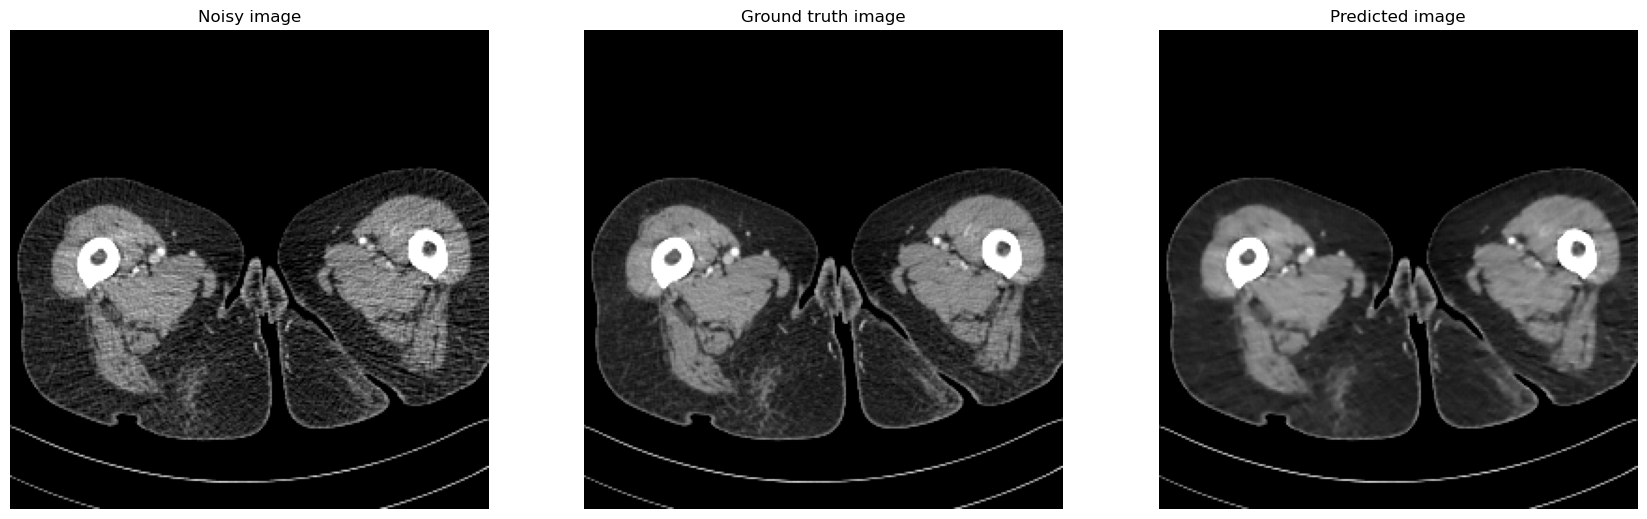

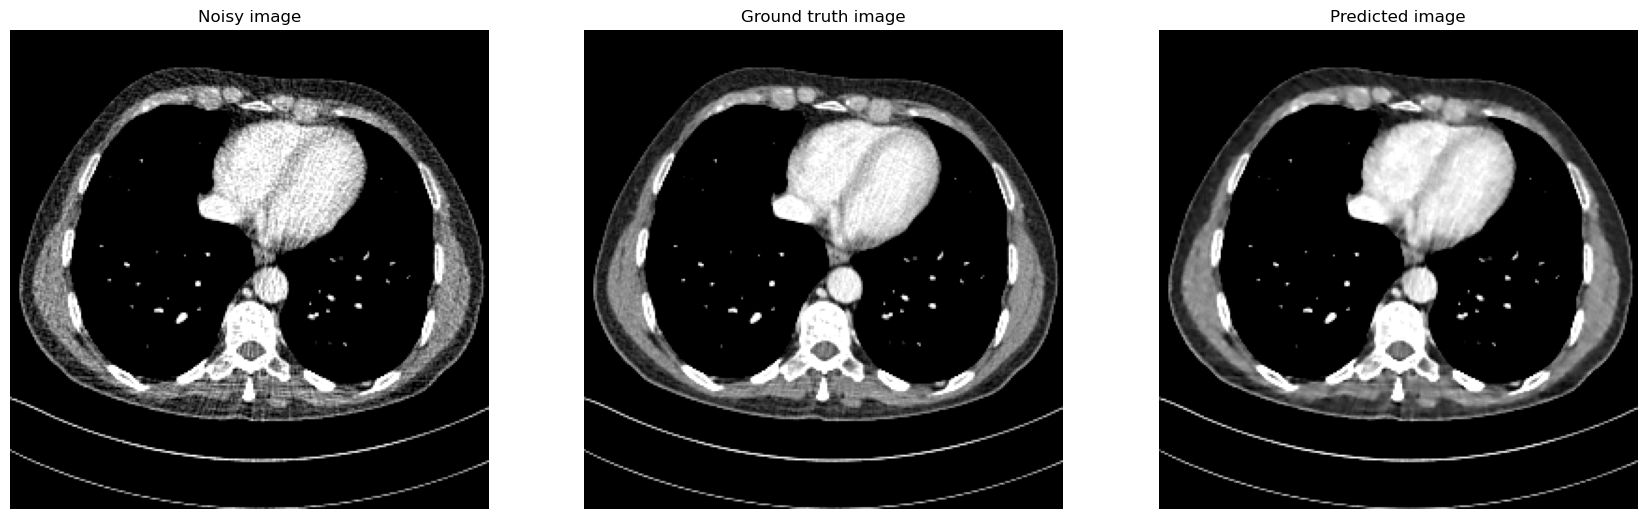

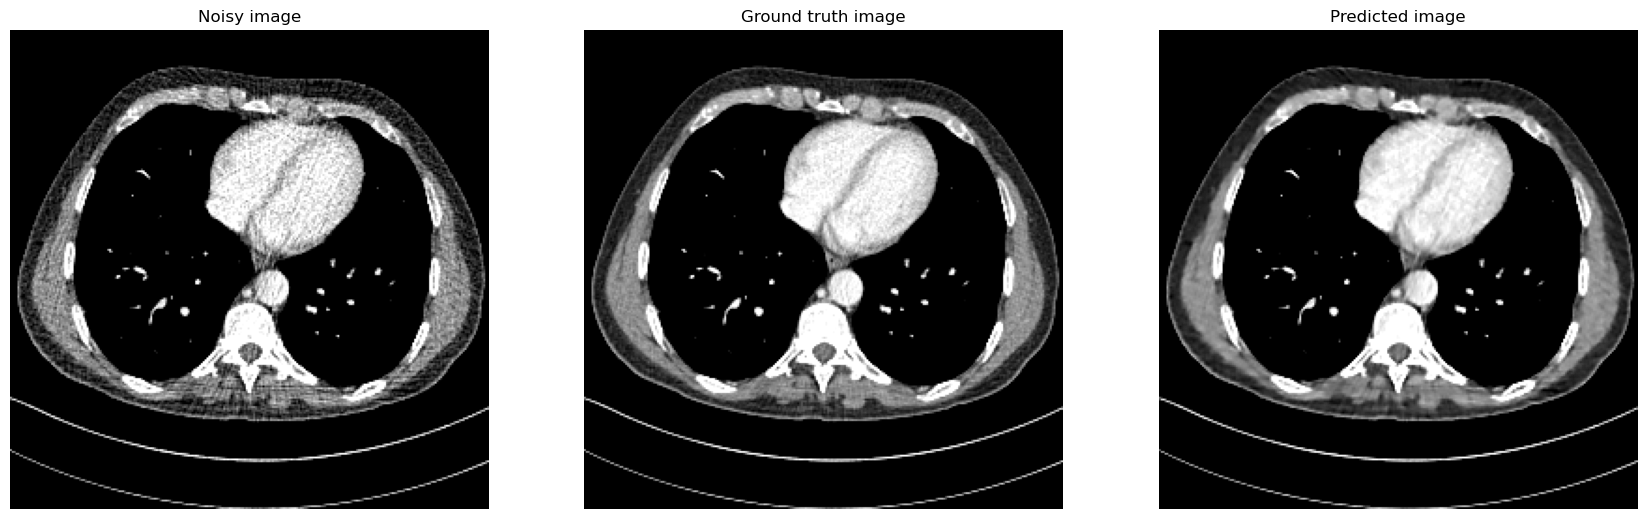

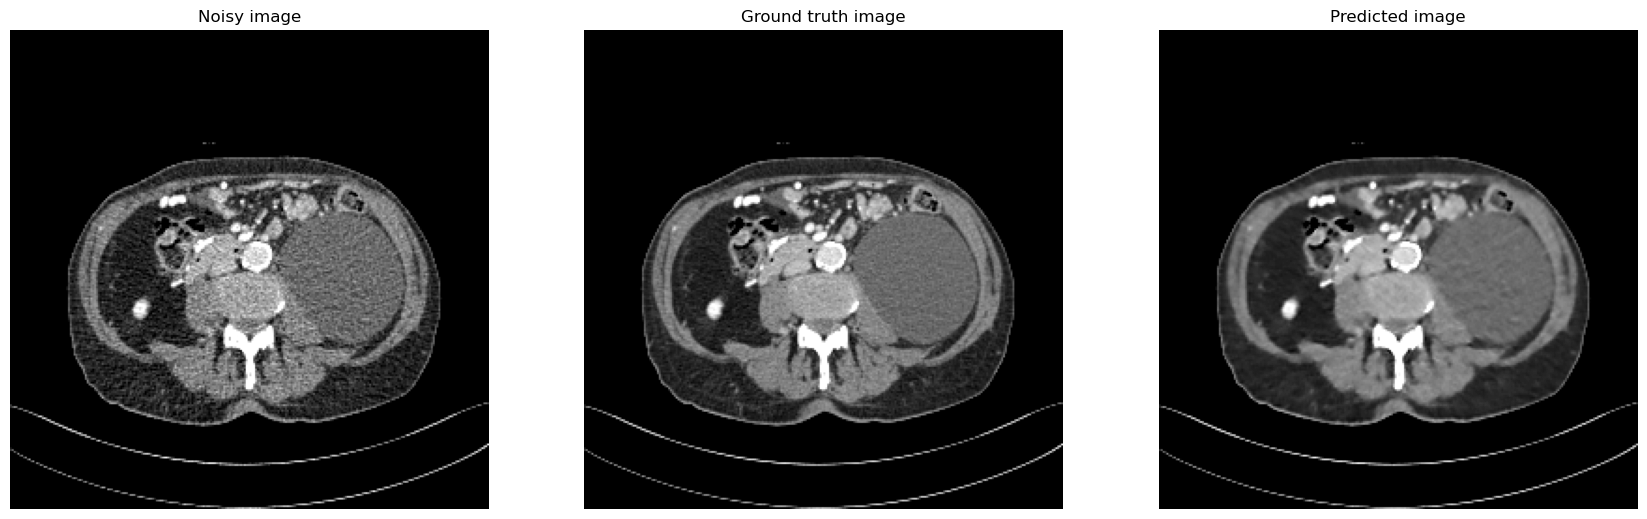

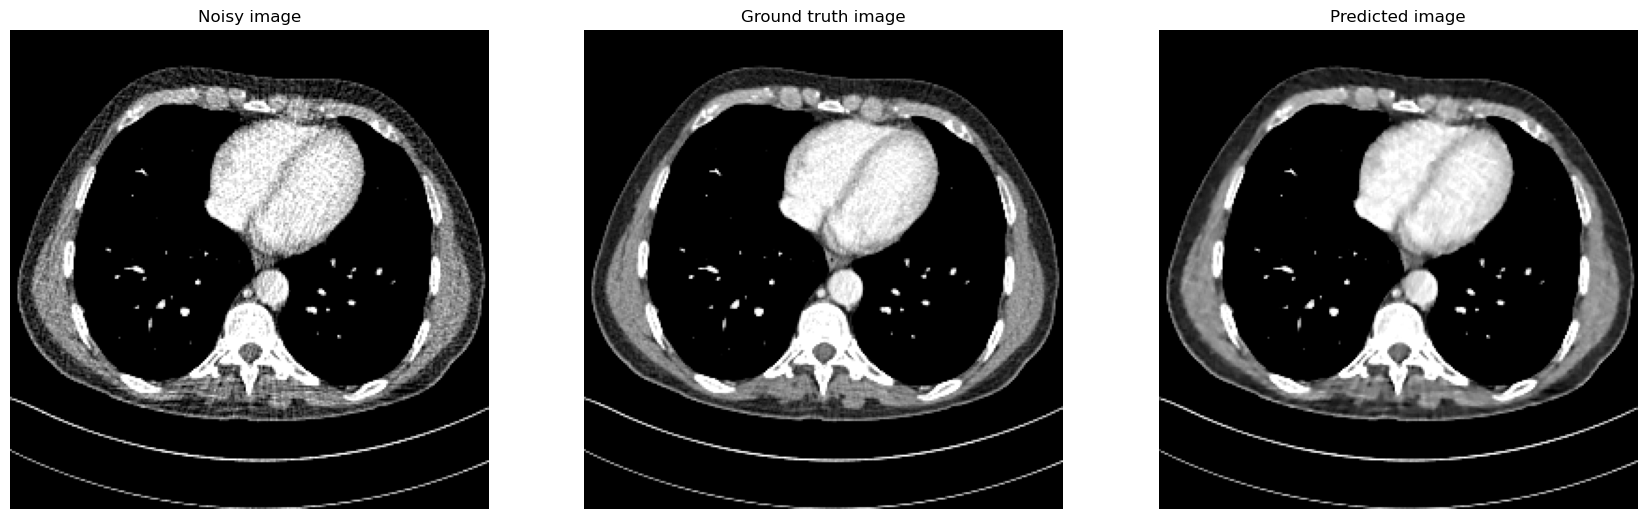

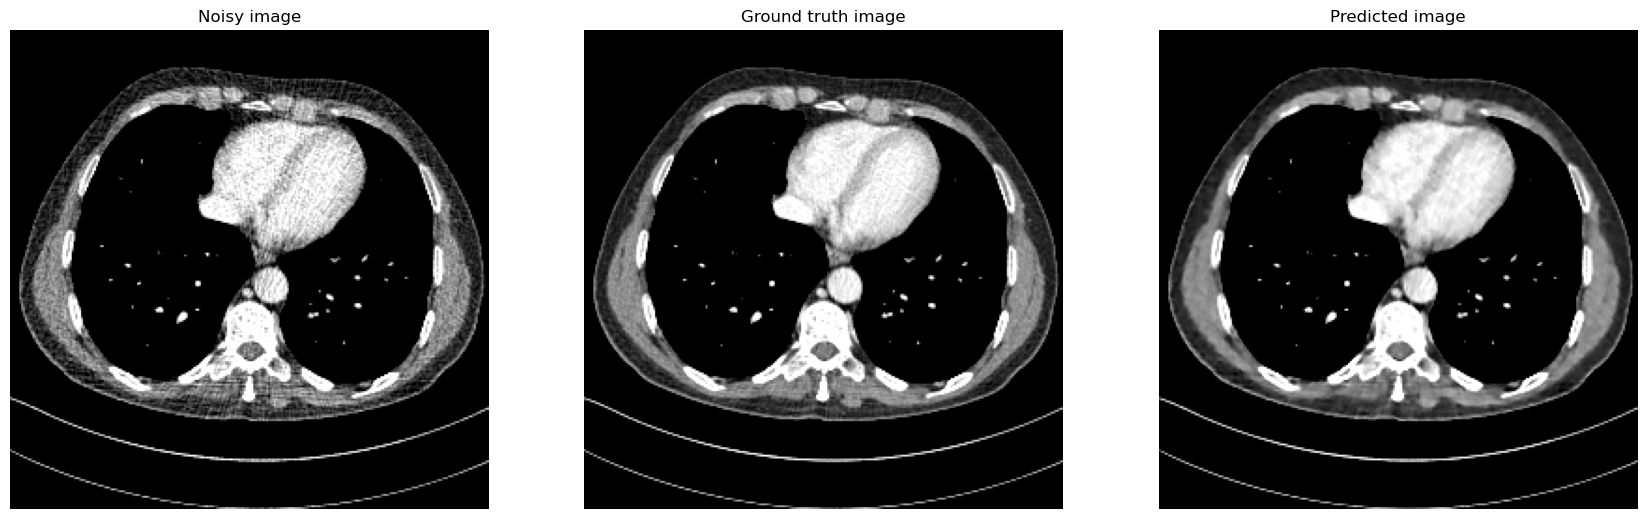

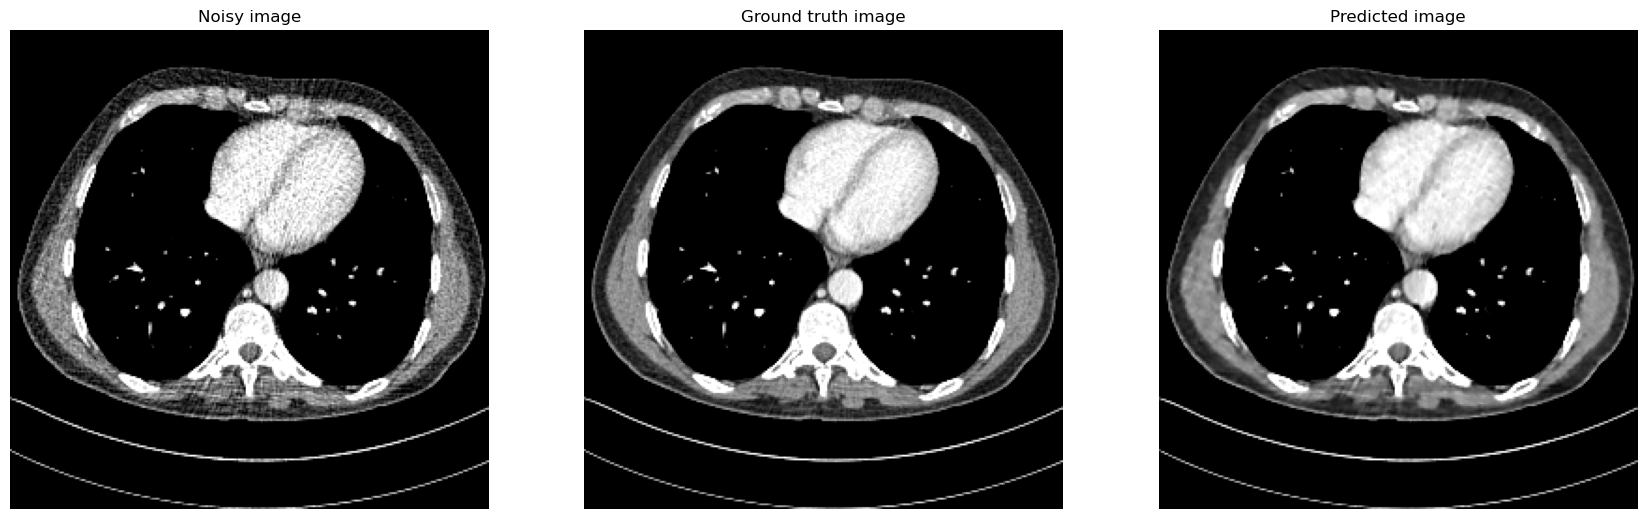

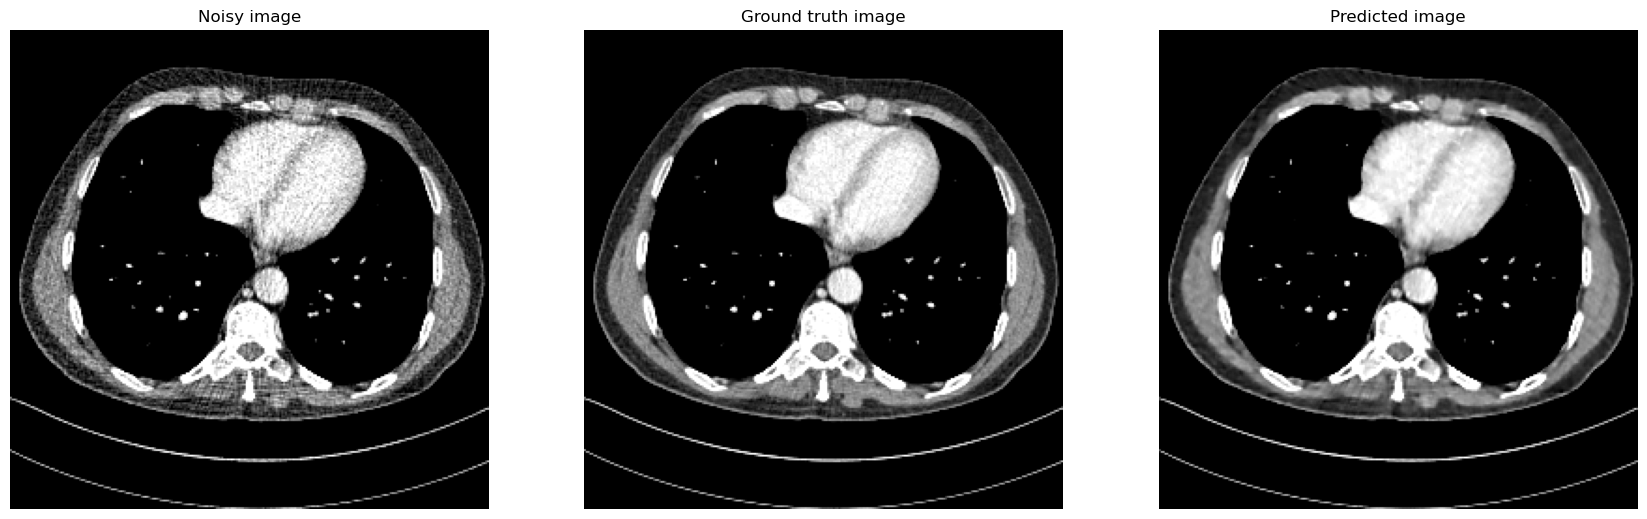

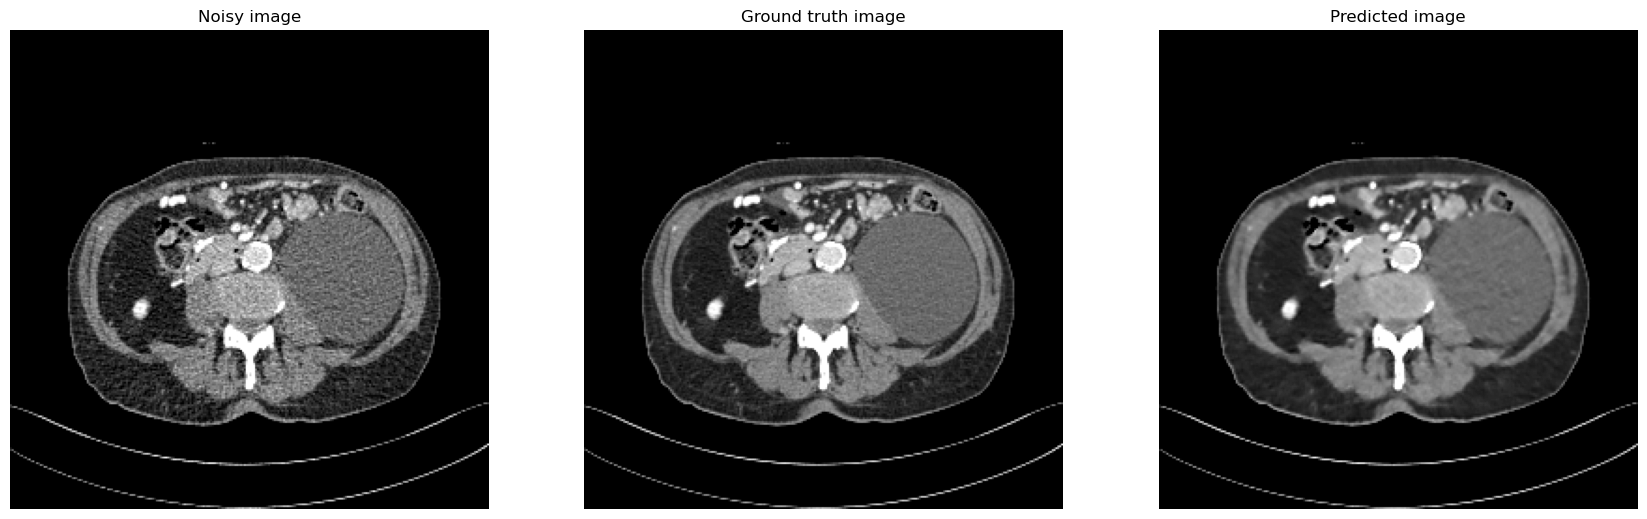

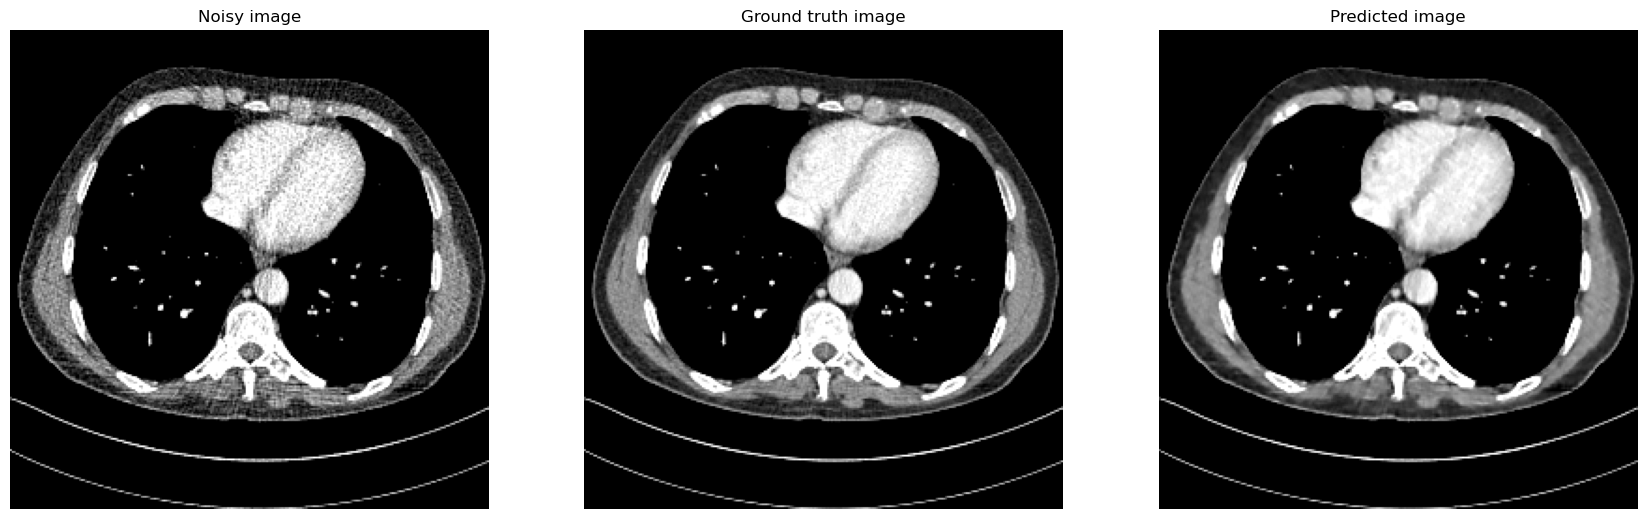

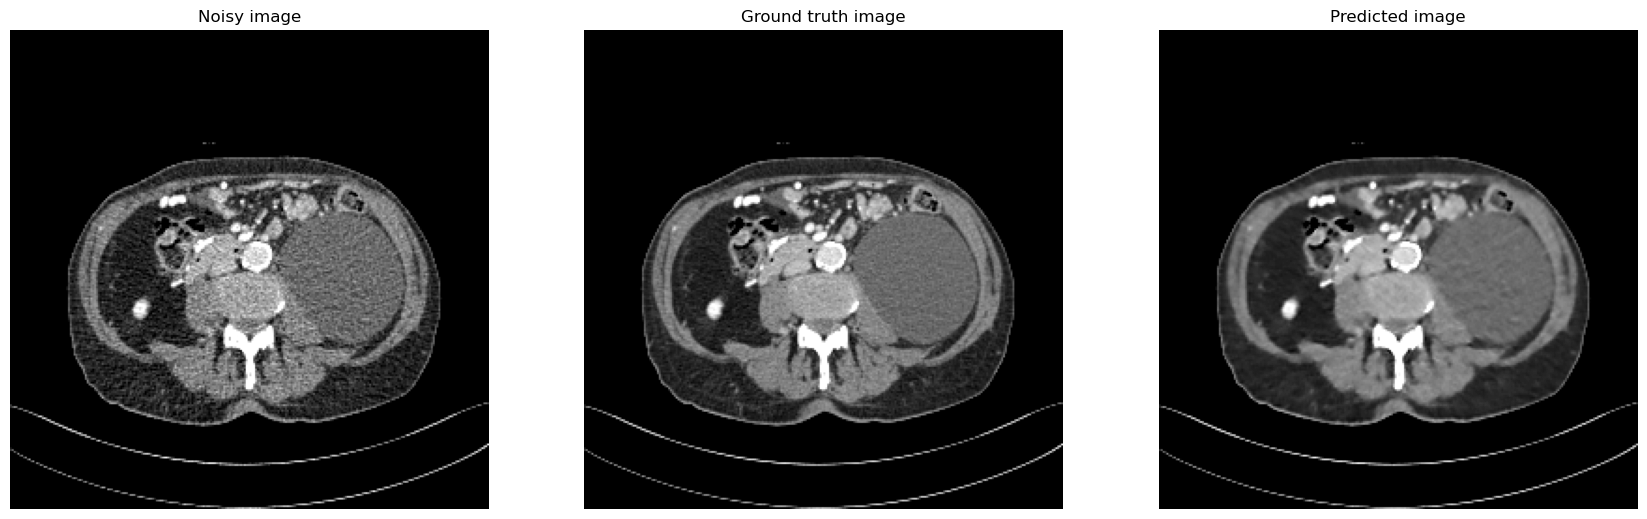

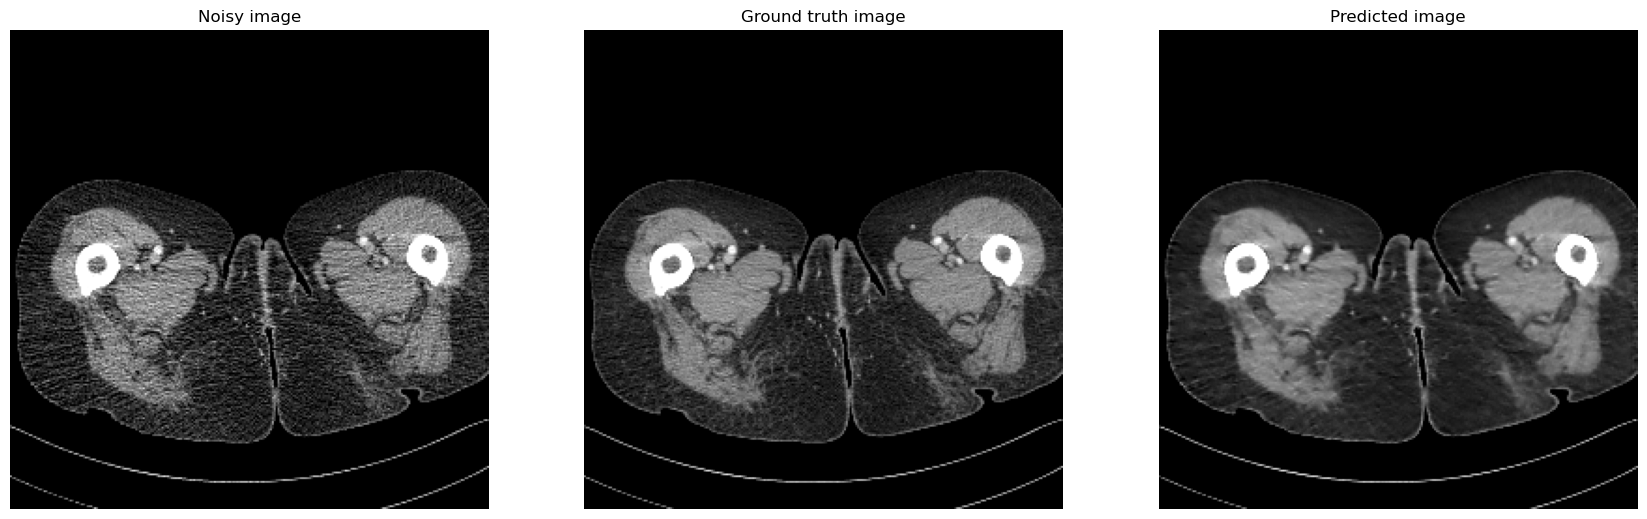

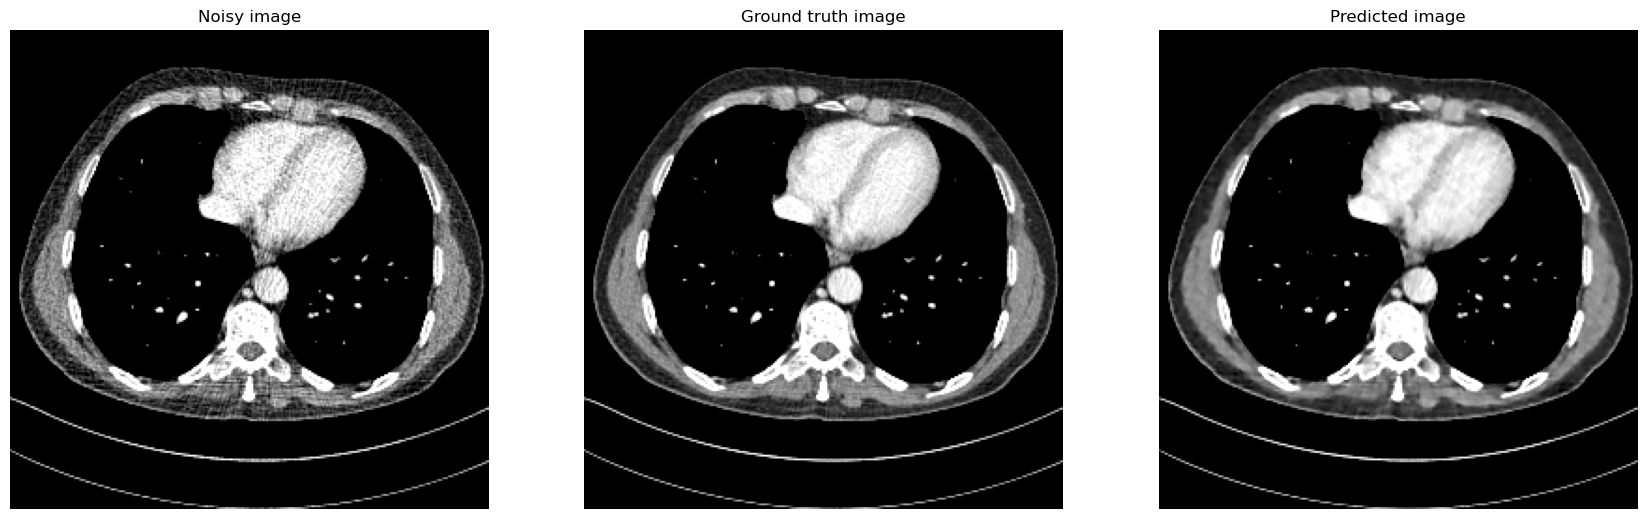

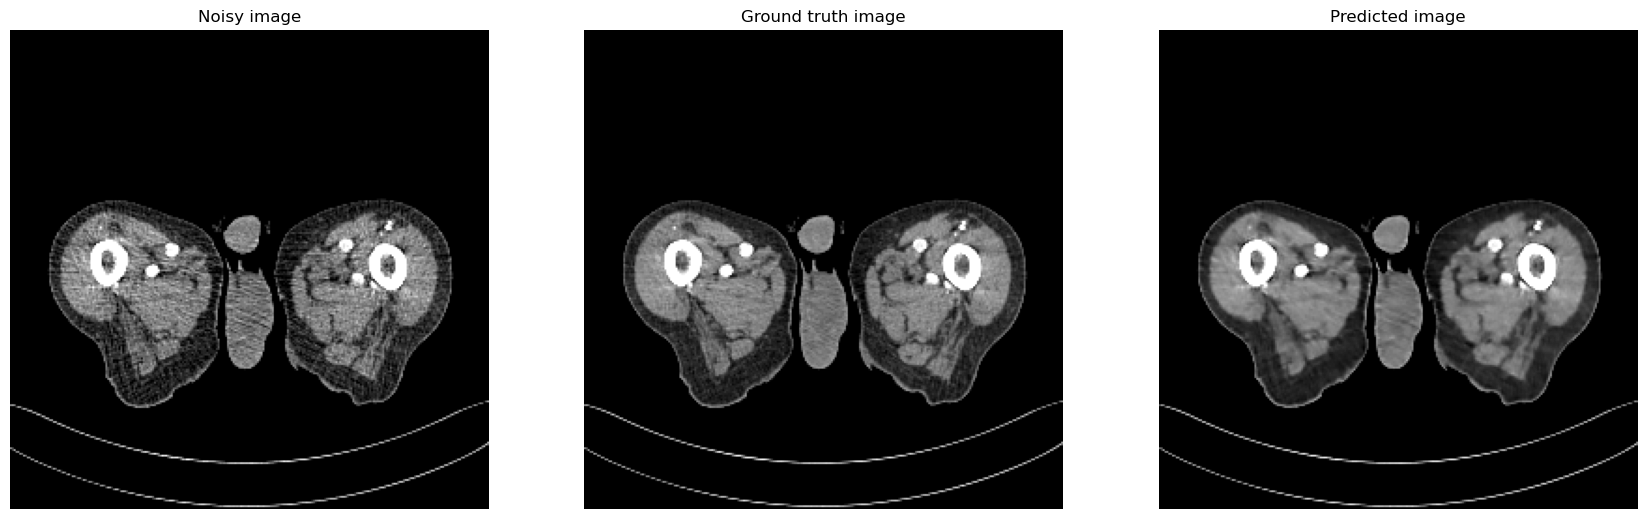

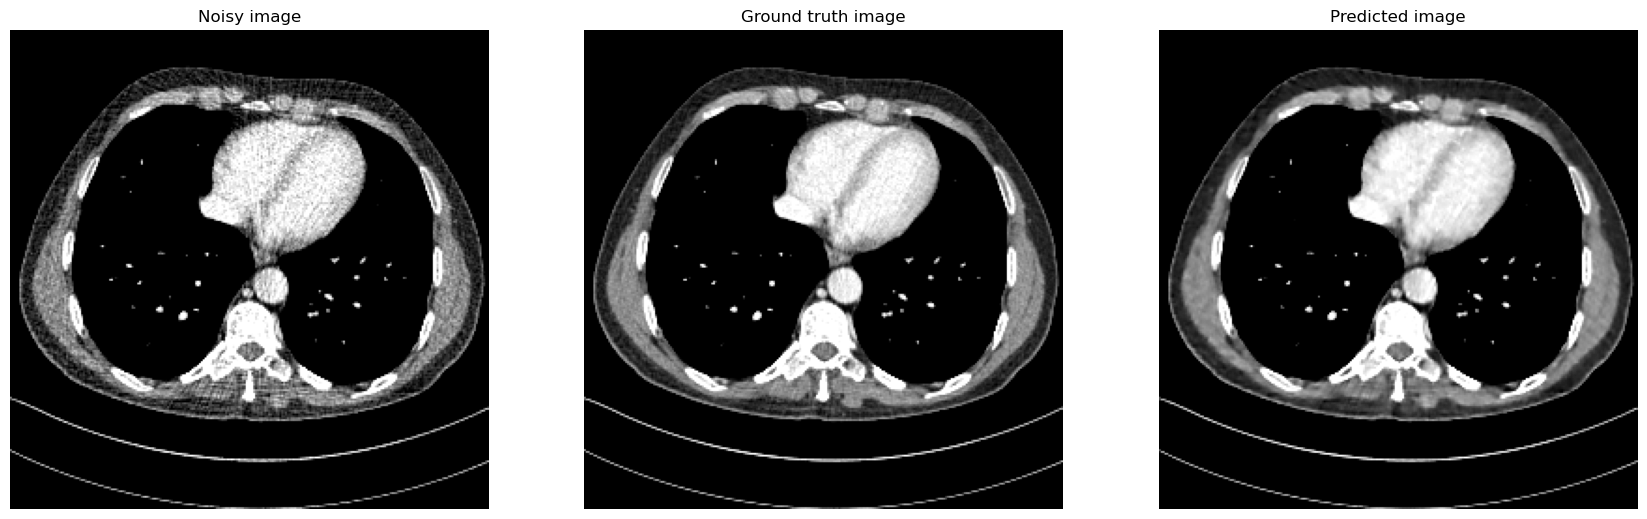

In [20]:
visualize_predictions(model, noisy_test_images, gt_test_images, len(noisy_test_images))
visualize_predictions(model, noisy_train_images, gt_train_images, len(noisy_train_images))

In [22]:
from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model, noisy_test_images)
psnr_original_mean = 0
psnr_prediction_mean = 0

print(predicted_images.shape, gt_test_images.shape)

i = 0
for gt_img, noisy_img, predicted_img in zip(gt_test_images, noisy_test_images, predicted_images):
    #predicted_img=  rgb2gray(predicted_images[i])
    #predicted_img = np.expand_dims(predicted_images, axis=-1)
    
    print(gt_img.shape, predicted_img.shape)
    
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)
    i = i + 1
psnr_original_mean/=gt_test_images.shape[0]
psnr_prediction_mean/=gt_test_images.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

1/1 [==============================] - 0s 94ms/step
(3, 256, 256, 1) (3, 256, 256, 1)
(256, 256, 1) (256, 256, 1)
(256, 256, 1) (256, 256, 1)
(256, 256, 1) (256, 256, 1)
Original average gt-noisy PSNR -> 44.59780844856004
Predicted average gt-predicted PSNR -> 47.492268079782775


In [23]:
from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model, noisy_test_images)
ssim_original_mean = 0
ssim_prediction_mean = 0

i = 0
for gt_img, noisy_img, predicted_img in zip(gt_test_images, noisy_test_images, predicted_images):
    #predicted_img=  rgb2gray(predicted_images[i])
    i = i + 1
    print(gt_img.shape, predicted_img.shape)


    ssim_original_mean += ssim(gt_img, noisy_img,     win_size=5,  channel_axis=2, data_range=1.0)
    ssim_prediction_mean += ssim(gt_img, predicted_img, win_size=5,  channel_axis=2, data_range=1.0)

ssim_original_mean/=gt_test_images.shape[0]
ssim_prediction_mean/=gt_test_images.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)

1/1 [==============================] - 0s 74ms/step
(256, 256, 1) (256, 256, 1)
(256, 256, 1) (256, 256, 1)
(256, 256, 1) (256, 256, 1)
Original average gt-noisy SSIM -> 0.9701922838037255
Predicted average gt-predicted SSIM -> 0.9879129861573842


dict_keys(['loss', 'val_loss', 'lr'])


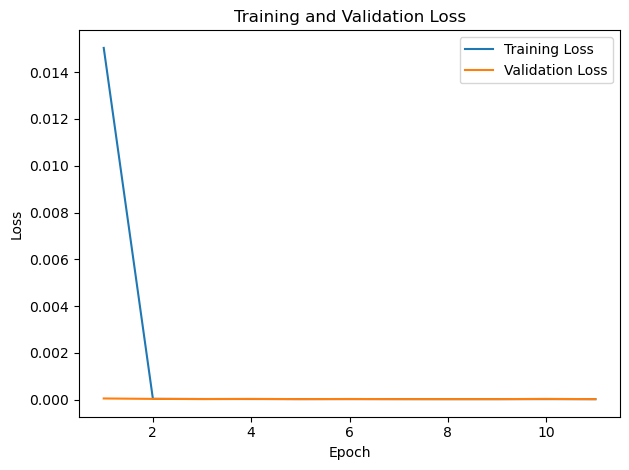

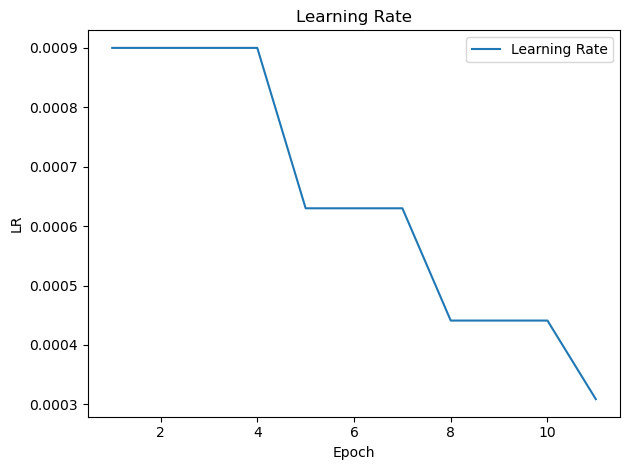

In [29]:
def view_model_history(history, psnr_or_accuracy):
    # Visualize model history.
    # Plot loss, accuracy, val_loss and val_accuracy

    # Get the number of epochs
    num_epochs = len(history['loss'])

    # Plot training and validation accuracy / PSNR values
    if psnr_or_accuracy == 'accuracy':
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(range(1, num_epochs + 1), history['accuracy'], label='Training Accuracy')
        plt.plot(range(1, num_epochs + 1), history['val_accuracy'], label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
    elif psnr_or_accuracy == 'psnr':
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(range(1, num_epochs + 1), history['psnr'], label='Training psnr')
        plt.plot(range(1, num_epochs + 1), history['val_psnr'], label='Validation psnr')
        plt.title('Training and Validation Psnr')
        plt.xlabel('Epoch')
        plt.ylabel('Psnr')
        plt.legend()
        
    # Plot training and validation loss values
    #plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), history['loss'], label='Training Loss')
    plt.plot(range(1, num_epochs + 1), history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    plt.plot(range(1, num_epochs + 1), history['lr'], label='Learning Rate')
    plt.title('Learning Rate')
    plt.xlabel('Epoch')
    plt.ylabel('LR')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    
history = np.load('data/mwcnn_history.npy', allow_pickle=True).item()
print(history.keys())
view_model_history(history, psnr_or_accuracy='non')